In [1]:
# %% --------------------------------------- Imports -------------------------------------------------------------------
import os
from time import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
import math
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
import keras.backend as K
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


path = ('/Users/carolinesklaver/Desktop/Capstone/NHANES/data/csv_data/')

import os
os.chdir(path)

SEED = 42

target = 'depressed'

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

## Get feature types

In [2]:
def var_type(df):
    # input dataframe
    # return continuous, non-continous, and multi-categorical features
 
    cols = df.columns
    cont = []
    non_cont = []
    cat_encode = []
    
    # get continuous variables
    for c in cols:
        if df[c].nunique() > 6:
            cont.append(c)
    
    # non cont is the difference
    non_cont = np.setdiff1d(cols, [cont])
    
    # multi-cat are those greater than 2
    for n in non_cont:
        if df[n].nunique() > 2:
            cat_encode.append(n)
    
    return cont, non_cont, cat_encode
    

## Encode multi-categorical features

In [3]:
def one_hot_encode(df, cat_encode):
    # takes in df and multi-cat features
    # returns df with features that are one-hot-encoded encoded and feature names
    
    cols = df.columns
    e_cols = list(set(cols).intersection(set(cat_encode)))
    df_encode = pd.get_dummies(df, columns=e_cols)
    
    features = np.setdiff1d(df_encode.columns, [target])

    return (df_encode, features)

## Split into training and testing & scale data

In [4]:
import pandas as pd
pd.options.mode.chained_assignment = None 
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

def split_train_test(df, features, cont):
    # take in dataframe
    # output training features and binary target
    # output testing features and binary target
    
    
    # divide into training and testing
    df_raw_train, df_raw_test = train_test_split(df, test_size=0.33, random_state=SEED)
    # Reset the index
    df_raw_train, df_raw_test = df_raw_train.reset_index(drop=True), df_raw_test.reset_index(drop=True)

    # split training into train and validation
    df_train_split, df_raw_val = train_test_split(df_raw_train, test_size=0.2, random_state=SEED)
    # Reset the index
    df_train_split, df_raw_val = df_train_split.reset_index(drop=True), df_raw_val.reset_index(drop=True)

   
    
    # Make a copy of df_raw_train
    df_train = df_train_split.copy(deep=True)
    df_val = df_raw_val.copy(deep=True)
    # Make a copy of df_raw_test
    df_test = df_raw_test.copy(deep=True)


    # get feautre matrix
    x_train = df_train[features]
    x_val = df_val[features]
    x_test = df_test[features]
    
    y_train = df_train[target]
    y_val = df_val[target]
    y_test = df_test[target]
    
    
    # ---------------------- scale the continuous features --------------------
    x_train.astype('float32')
    x_val.astype('float32')
    x_test.astype('float32')

    cont_ss = []
    for var in cont:
        if var in x_train.columns:
            cont_ss.append(var)

    x_train[cont_ss] = ss.fit_transform(x_train[cont_ss])
    x_val[cont_ss] =ss.fit_transform(x_val[cont_ss])
    x_test[cont_ss] = ss.transform(x_test[cont_ss])
    # ---------------------------------------------------------------------------
    
    # get 2D output shape
    y_train_binary = keras.utils.to_categorical(y_train)
    y_val_binary = keras.utils.to_categorical(y_val)
    y_test_binary = keras.utils.to_categorical(y_test)
    
    # get input dimentions
    input_n = df_train.shape[1]-1

    print('Training data shape:', df_train.shape)
    print('Val data shape:', df_val.shape)
    print('Test data shape:', df_test.shape)
    print('Input shape:', input_n)
    
    
    return x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n



# Keras NN Model

In [5]:
def keras_model(input_n):

    # Define the model architecture
    model = keras.Sequential()

    model.add(layers.Dense(200, activation='relu' , input_dim=input_n))
    model.add(Dropout(0.2))
    model.add(layers.Dense(200, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(60, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(2, activation='softmax'))

    # print(model.summary())

    return model

In [6]:
import keras
from keras import layers
from sklearn.model_selection import KFold
import numpy as np
import keras.backend as K
K.clear_session()
tf.config.experimental.set_visible_devices([], 'GPU')

# --------------------------------------- Plots ---------------------------------------
from matplotlib import pyplot as plt

def acc_loss_plots(hist):
    # list all data in history
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [7]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_1 = 25
num_folds=3

def nn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = keras_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.rmsprop()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt,metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_1, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_1, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model



# CNN model

In [8]:
from __future__ import print_function    
from keras.models import Sequential
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from keras import backend as K

def cnn_model(input_n):
    model = Sequential()
    model.add(layers.Reshape((input_n,1), input_shape=(input_n,)))
    model.add(Conv1D(32, (2), input_shape=(input_n,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))


    # print(model.summary())
    
    return model

In [9]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


# Define the K-fold Cross Validator
BATCH_SIZE=32
EPOCHS_2 = 15
num_folds=3

def cnn_kfold(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    inputs = np.concatenate((x_train, x_val), axis=0)
    targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):

        model = cnn_model(input_n)
        
        if fold_no==1:
            print(model.summary())

        opt = keras.optimizers.Adam()

        model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        if balanced_batches==True:
            training_generator, steps_per_epoch = balanced_batch_generator(inputs[train],targets[train],
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
            history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(inputs[test], targets[test]),
                                    epochs=EPOCHS_2, verbose=0)

        else:
            history = model.fit(inputs[train],targets[train], #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(inputs[test], targets[test]),
                        epochs=EPOCHS_2, verbose=0)



        # Generate generalization metrics
        scores = model.evaluate(inputs[test], targets[test], verbose=1)
        
        # Generate a print
        print('------------------------------------------------------------------------')
        print(
        f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; '
        f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
        f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
        # plot Testing/Val accuracy and loss    
        if fold_no==num_folds:
            # plot the accuracy and loss for training/val by epoch
            acc_loss_plots(history)


        # Increase fold number
        fold_no = fold_no + 1
        
        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

In [10]:
from imblearn.keras import balanced_batch_generator
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score

BATCH_SIZE=32
EPOCHS_2 = 20

def cnn(df, balanced_batches=False):
    
    cont, non_cont, cat_encode = var_type(df)
    df_encoded, features = one_hot_encode(df, cat_encode)
    x_train,x_val, x_test, y_train_binary, y_val_binary, y_test_binary, input_n = split_train_test(df_encoded, features, cont)
    
    # Merge inputs and targets
    # inputs = np.concatenate((x_train, x_val), axis=0)
    # targets = np.concatenate((y_train_binary, y_val_binary), axis=0)

    model = cnn_model(input_n)
    print(model.summary())

    opt = keras.optimizers.Adam()

    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy', keras.metrics.Precision(name='precision'),
                                        keras.metrics.Recall(name='recall'),
                                        keras.metrics.AUC(name='AUC')])

    # Generate a print
    print('------------------------------------------------------------------------')

    if balanced_batches==True:
        training_generator, steps_per_epoch = balanced_batch_generator(x_train, y_train_binary,
                                                                   batch_size=BATCH_SIZE,
                                                                   random_state=SEED)
        history = model.fit_generator(generator=training_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    validation_data=(x_val, y_val_binary),
                                    epochs=EPOCHS_2, verbose=1)

    else:
        history = model.fit(x_train, y_train_binary, #class_weight=class_weights,
                        batch_size=BATCH_SIZE, validation_data=(x_val, y_val_binary),
                        epochs=EPOCHS_2, verbose=1)



    # Generate generalization metrics
    scores = model.evaluate(x_val, y_val_binary, verbose=1)
        
    # Generate a print
    print('------------------------------------------------------------------------')
    print(
    f'Score for val cnn: {model.metrics_names[0]} of {scores[0]}; '
    f' {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]};'
    f' {model.metrics_names[3]} of {scores[3]}; {model.metrics_names[4]} of {scores[4]};')
    
    # plot Testing/Val accuracy and loss    
    acc_loss_plots(history)

        
    y_pred = model.predict(x_test)

    print(confusion_matrix(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('F1 score:',f1_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Precision:',precision_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Recall:',recall_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('Accuracy:', accuracy_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    print('ROC AUC:', roc_auc_score(y_test_binary.argmax(axis=1), y_pred.argmax(axis=1)))
    
    return model

## Original Data from NHANES

In [11]:
df_raw_knn =  pd.read_csv('df_progressive_knn_2.csv')  # 53 columns
df_raw_knn.head()

,SEQN,year,depressed,race_ethnicity,edu_level,#_ppl_household,age,gender,marital_status,annual_HI,...,systolic_BP,diastolic_BP,BMI,waist_C,#meals_fast_food,min_sedetary,doc_HPV,bone_mineral_density,difficult_hearing,doc_COPD
0,31131.0,2005-2006,0.0,4.0,4.0,4.0,44.0,2.0,1.0,11.0,...,144.0,74.0,30.90,96.0,1.6,336.0,0.0,1.0,0.0,0.0
1,31132.0,2005-2006,0.0,3.0,5.0,2.0,70.0,1.0,1.0,11.0,...,138.0,60.0,24.74,96.5,1.0,348.0,0.0,0.8,0.0,0.0
2,31134.0,2005-2006,0.0,3.0,3.0,2.0,73.0,1.0,1.0,8.0,...,130.0,68.0,30.63,117.1,0.2,480.0,0.0,0.8,0.0,0.0
3,31139.0,2005-2006,0.0,2.0,2.0,3.0,18.0,2.0,5.0,11.0,...,110.0,64.0,29.45,84.0,4.0,516.0,0.0,0.6,0.0,0.0
4,31143.0,2005-2006,0.0,3.0,3.0,3.0,19.0,1.0,5.0,11.0,...,108.0,62.0,22.57,84.2,1.8,336.0,0.0,1.0,0.0,0.0


Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               16000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_______________

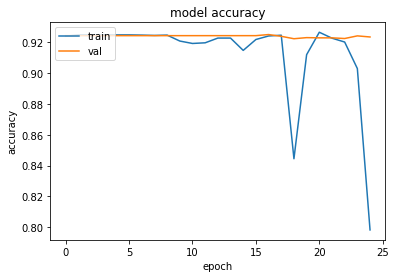

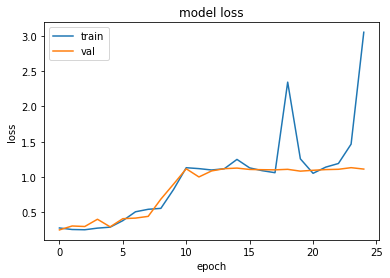

[[9524   57]
 [ 747   20]]
F1 score: 0.047393364928909956
Precision: 0.2597402597402597
Recall: 0.02607561929595828
Accuracy: 0.9223038268264399
ROC AUC: 0.5100631723449837


In [14]:
nn_kfold(df_raw_knn)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 78, 32)            128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 77, 32)            128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 64)            4160      
_______________

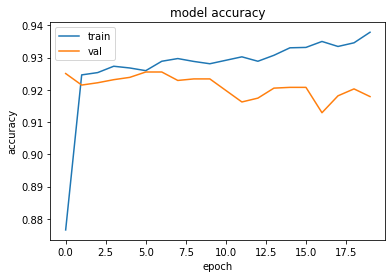

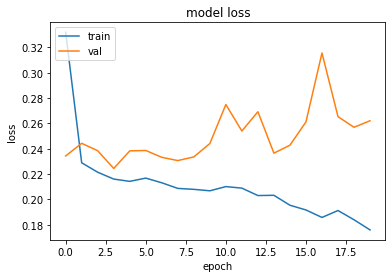

[[9365  216]
 [ 637  130]]
F1 score: 0.23360287511230907
Precision: 0.37572254335260113
Recall: 0.1694915254237288
Accuracy: 0.9175686122922304
ROC AUC: 0.573473452932092


In [15]:
cnn(df_raw_knn)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               16000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
_______________

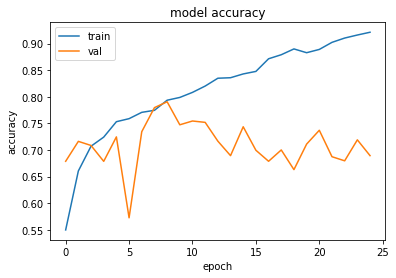

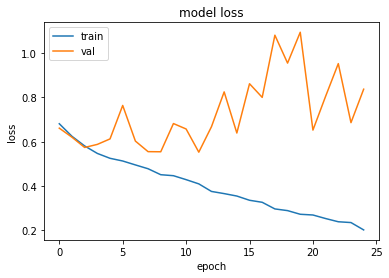

[[6542 3039]
 [ 263  504]]
F1 score: 0.23387470997679816
Precision: 0.14225232853513972
Recall: 0.6571056062581486
Accuracy: 0.6809045226130653
ROC AUC: 0.6699576669219979


In [16]:
nn_kfold(df_raw_knn, balanced_batches=True)

Training data shape: (16807, 80)
Val data shape: (4202, 80)
Test data shape: (10348, 80)
Input shape: 79
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 79, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 78, 32)            96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 78, 32)            128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 77, 32)            2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 77, 32)            128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 76, 64)            4160      
_______________

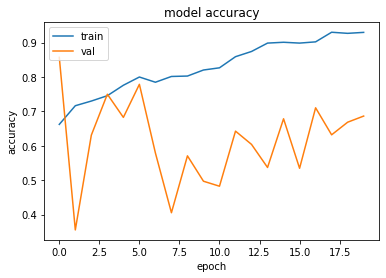

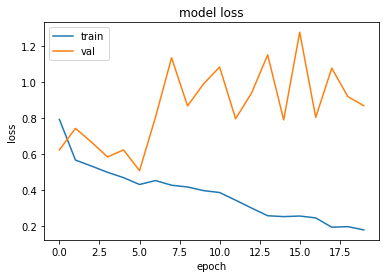

[[6588 2993]
 [ 272  495]]
F1 score: 0.2326674500587544
Precision: 0.1419151376146789
Recall: 0.6453715775749674
Accuracy: 0.6844800927715501
ROC AUC: 0.6664912370705439


In [17]:
cnn(df_raw_knn, balanced_batches=True)

## Data with more features from NHANES

In [12]:
# read in normal knn imputed more features data
df_raw_knn_OG =  pd.read_csv('df_progressive_knn_ext_ext.csv')  # 112 columns
df_raw_knn_OG.head()


,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium,serum_zinc,serum_creatinine,lab_VitB12,bone_mineral_density,difficult_hearing,difficult_seeing,difficult_walking,difficult_errands,doc_COPD
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,113.2,73.0,188.2,415.6,0.8,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,121.0,81.4,94.2,266.4,0.8,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,129.6,78.8,138.4,549.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,130.4,87.6,66.0,486.2,0.8,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,112.8,82.6,146.2,547.6,1.0,0.0,0.0,0.0,0.0,0.0


Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               33400     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

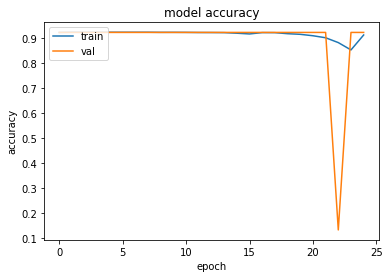

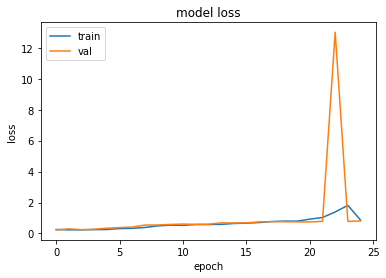

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
nn_kfold(df_raw_knn_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 165, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 163, 64)           4160      
__________

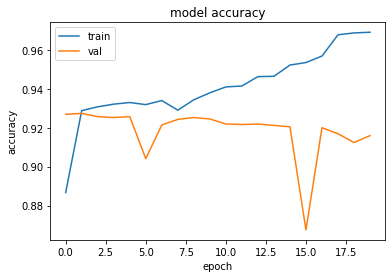

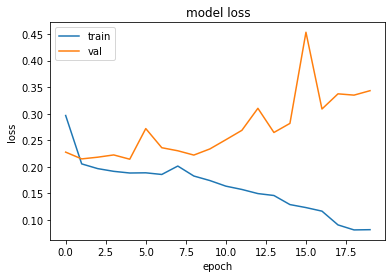

[[9255  326]
 [ 586  181]]
F1 score: 0.2841444270015699
Precision: 0.35700197238658776
Recall: 0.23598435462842243
Accuracy: 0.9118670274449169
ROC AUC: 0.6009793394058509


In [20]:
cnn(df_raw_knn_OG)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               33400     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

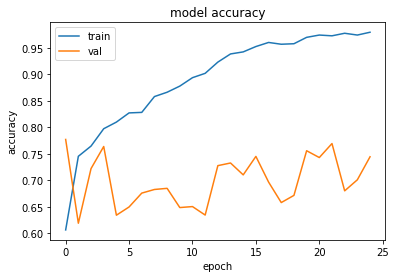

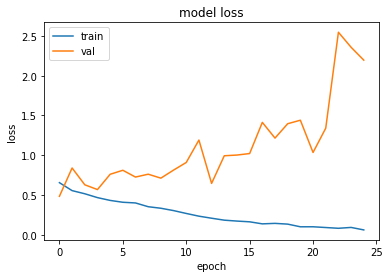

[[7111 2470]
 [ 245  522]]
F1 score: 0.27773343974461295
Precision: 0.17446524064171123
Recall: 0.6805736636245111
Accuracy: 0.7376304599922691
ROC AUC: 0.7113858820157835


In [21]:
nn_kfold(df_raw_knn_OG, balanced_batches=True)

Training data shape: (16807, 167)
Val data shape: (4202, 167)
Test data shape: (10348, 167)
Input shape: 166
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 166, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 165, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 165, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 164, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 163, 64)           4160      
__________

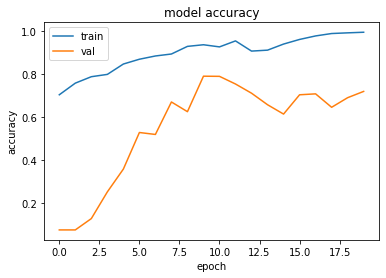

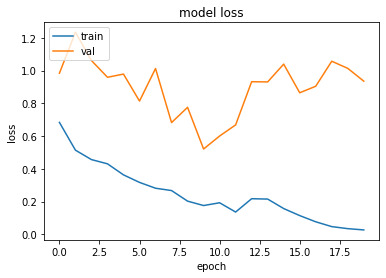

[[6872 2709]
 [ 226  541]]
F1 score: 0.2693552402290266
Precision: 0.16646153846153847
Recall: 0.7053455019556715
Accuracy: 0.7163703131039815
ROC AUC: 0.7112991991565228


In [22]:
cnn(df_raw_knn_OG, balanced_batches=True)

## Subset of NHANES features 1/3

In [13]:
subset1 = ['depressed','tried_lose_weight', 'triglyceride', 'tot_cholesterol', 'glycohemoglobin', 
           'herpes_2', 'HIV', 'rbc_folate', 'serum_folate', 'fasting_glucose', 'lab_VitD', 
           'systolic_BP', 'diastolic_BP', 'pulse', 'BMI', 'waist_C', 'VitD', '#meals_fast_food', 
           'monthly_income', 'savings_5000', 'min_sedetary', 'doc_HPV', 'oral_rec', 
           'difficult_remembering', 'prob_smell', 'prob_tatse', 'persistent_cold', 
           'nasal_congestion', 'serum_selenium', 'serum_zinc', 'serum_creatinine', 
           'lab_VitB12', 'bone_mineral_density', 'difficult_hearing', 'difficult_seeing', 
           'difficult_walking', 'difficult_errands']

df_knn_sub1 = df_raw_knn_OG[subset1]


Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_103 (Dropout)        (None, 100)               0         
______________

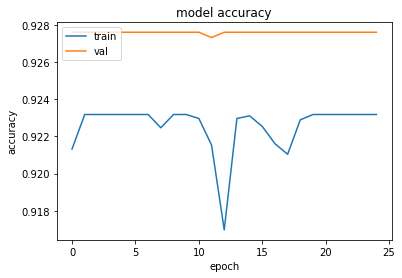

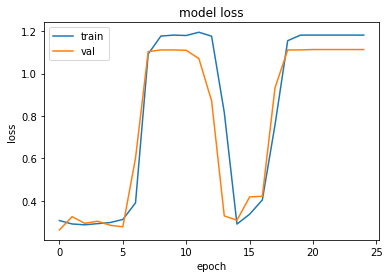

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
nn_kfold(df_knn_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 39, 1)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 38, 32)            96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 38, 32)            128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 37, 32)            2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 37, 32)            128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 36, 64)            4160      
______________

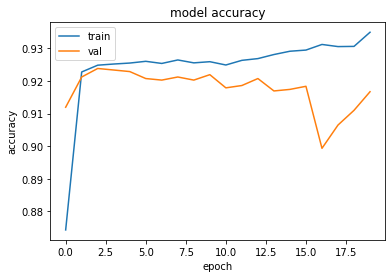

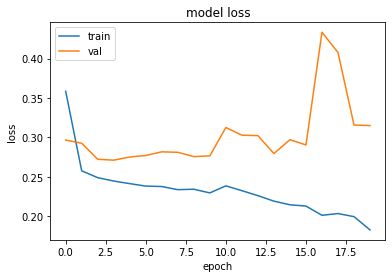

[[9485   96]
 [ 721   46]]
F1 score: 0.10121012101210122
Precision: 0.323943661971831
Recall: 0.05997392438070404
Accuracy: 0.9210475454194047
ROC AUC: 0.5249770467326754


In [25]:
cnn(df_knn_sub1)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               8000      
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_128 (Dropout)        (None, 100)               0         
______________

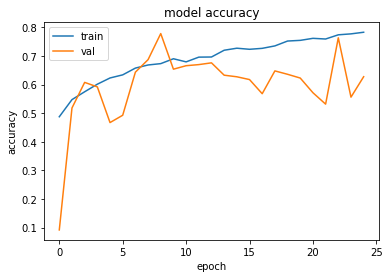

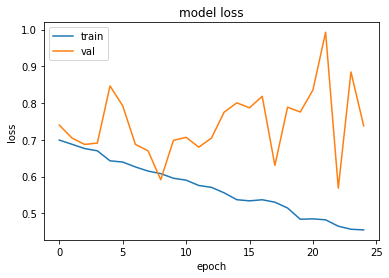

[[6006 3575]
 [ 372  395]]
F1 score: 0.166772218703821
Precision: 0.09949622166246852
Recall: 0.5149934810951761
Accuracy: 0.6185736374178585
ROC AUC: 0.5709295763684836


In [26]:
nn_kfold(df_knn_sub1, balanced_batches=True)

Training data shape: (16807, 40)
Val data shape: (4202, 40)
Test data shape: (10348, 40)
Input shape: 39
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 39, 1)             0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 38, 32)            96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 38, 32)            128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 37, 32)            2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 37, 32)            128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 36, 64)            4160      
______________

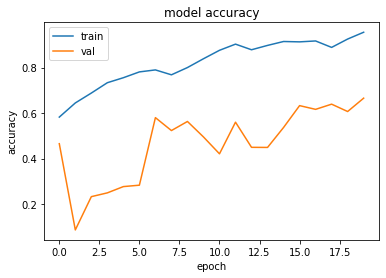

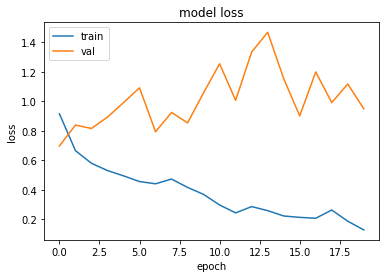

[[6455 3126]
 [ 386  381]]
F1 score: 0.17828731867103415
Precision: 0.1086398631308811
Recall: 0.49674054758800523
Accuracy: 0.6606107460378817
ROC AUC: 0.5852349017034065


In [27]:
cnn(df_knn_sub1, balanced_batches=True)

## Subset intuitively chosen 1/2

In [14]:
subset2 = ['depressed', 'race_ethnicity', 'edu_level', 'age', 'gender', 'annual_HI',
              'marital_status', 'special_diet', 'protein', 'carb','sugar', 'fiber', 'fat', 
               'diet_chol', 'VitB6', 'folate', 'VitB12', 'doc_diabetes','how_healthy_diet', 
               'used_CMH', 'gen_health_cond','healthcare_past_yr', 'run_out_food', 'afford_balanced_meals',
              'food_security_cat', 'food_stamps', 'doc_asthma','doc_overweight', 'doc_arthritis', 
               'doc_CHD','doc_heart_attack', 'doc_stroke', 'doc_chronic_bronchitis',
               'doc_liver_condition', 'doc_thyroid_problem', 'doc_cancer','anemia', 'doc_kidney',
               'work_type', 'embarassed_mouth', 'lab_B12', 'vigorous_activity','moderate_activity', 
               'hours_TV', 'hours_computer','manage_$_difficult', 'doc_sleeping_disorder','hrs_sleep',
              'smoked_5days', 'sexual_orientation','alcoholic', 'consider_weight','triglyceride', 'tot_cholesterol',
              'rbc_folate','fasting_glucose', 'lab_VitD','BMI','min_sedetary','difficult_remembering',
              'persistent_cold','lab_VitB12','difficult_errands', 'doc_COPD']

df_knn_sub2 = df_raw_knn_OG[subset2]

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
__________

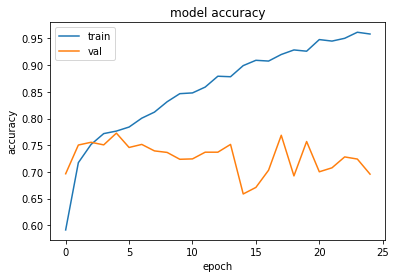

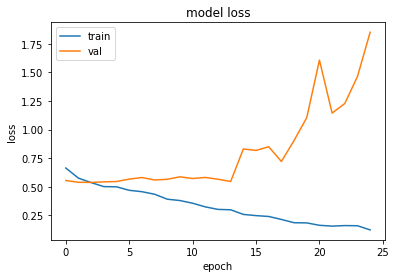

[[6455 3126]
 [ 214  553]]
F1 score: 0.24876293297345933
Precision: 0.15031258494156022
Recall: 0.7209908735332464
Accuracy: 0.6772323154232702
ROC AUC: 0.6973600646760272


In [29]:
nn_kfold(df_knn_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 101, 64)           4160      
__________

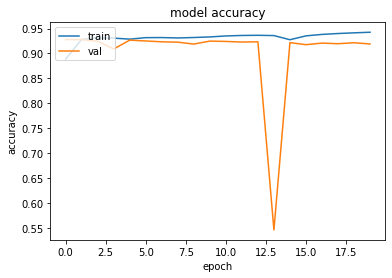

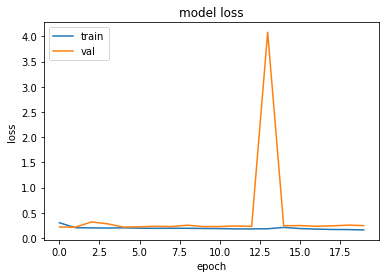

[[9399  182]
 [ 626  141]]
F1 score: 0.25871559633027524
Precision: 0.43653250773993807
Recall: 0.18383311603650587
Accuracy: 0.9219172787011983
ROC AUC: 0.5824185932964075


In [30]:
cnn(df_knn_sub2)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 200)               21000     
_________________________________________________________________
dropout_176 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_178 (Dropout)        (None, 100)               0         
__________

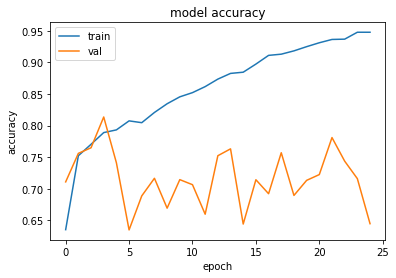

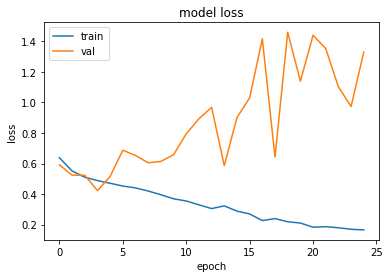

[[5949 3632]
 [ 175  592]]
F1 score: 0.23722700861550788
Precision: 0.14015151515151514
Recall: 0.771838331160365
Accuracy: 0.6321028218013143
ROC AUC: 0.6963773640980826


In [31]:
nn_kfold(df_knn_sub2, balanced_batches=True)

Training data shape: (16807, 105)
Val data shape: (4202, 105)
Test data shape: (10348, 105)
Input shape: 104
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 104, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 103, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 103, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 102, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 102, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 101, 64)           4160      
__________

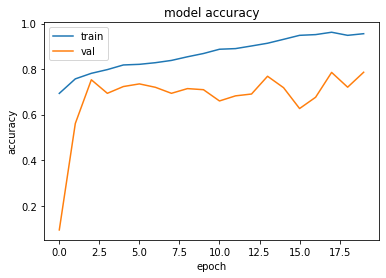

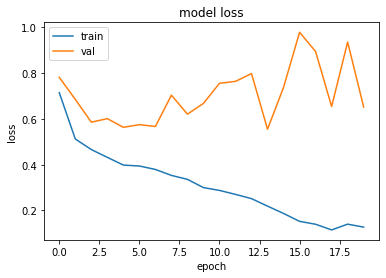

[[7714 1867]
 [ 327  440]]
F1 score: 0.2862719583604424
Precision: 0.1907238838318162
Recall: 0.5736636245110821
Accuracy: 0.7879783533049864
ROC AUC: 0.6893993939276004


In [32]:
cnn(df_knn_sub2, balanced_batches=True)

## Created new features (categorical)

In [13]:
df_raw_knn_ext =  pd.read_csv('df_feature_knn_ext.csv')

df_ext_square = df_raw_knn_ext[df_raw_knn_ext.columns.drop(list(df_raw_knn_ext.filter(regex='_2')))]

In [46]:
df_ext_square.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,hours_screen,limited,taste_smell,difficult_everyday,combined_BP,drugs_alcohol,people_per_rooms,sexuality,race_cat,diet_tot_VitB
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,2.0,0.0,0.0,0.0,218.0,0.0,0.500000,0.0,3.0,300.415
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,2.0,0.0,0.0,0.0,198.0,0.0,0.250000,0.0,2.0,814.422
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,1.0,0.0,1.0,0.0,198.0,0.0,0.285714,0.0,2.0,288.623
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,8.0,0.0,0.0,0.0,174.0,0.0,0.375000,0.0,1.0,308.428
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,6.0,0.0,0.0,0.0,170.0,0.0,0.428571,0.0,2.0,536.671


Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_233 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_201 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_234 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_202 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_203 (Dropout)        (None, 100)               0         
__________

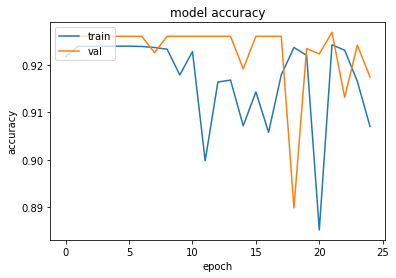

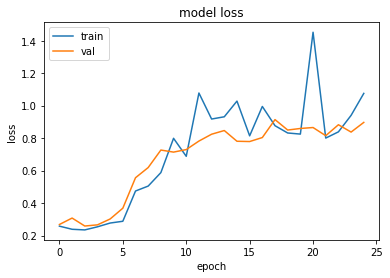

[[9345  236]
 [ 633  134]]
F1 score: 0.2357080035180299
Precision: 0.3621621621621622
Recall: 0.17470664928292046
Accuracy: 0.916022419791264
ROC AUC: 0.5750372824746718


In [34]:
nn_kfold(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 186, 1)            0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 185, 32)           96        
_________________________________________________________________
batch_normalization_41 (Batc (None, 185, 32)           128       
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 184, 32)           2080      
_________________________________________________________________
batch_normalization_42 (Batc (None, 184, 32)           128       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 183, 64)           4160      
__________

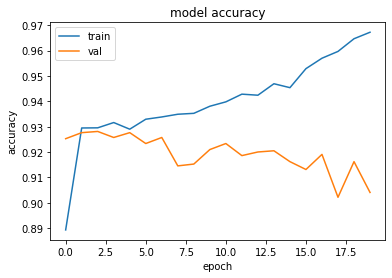

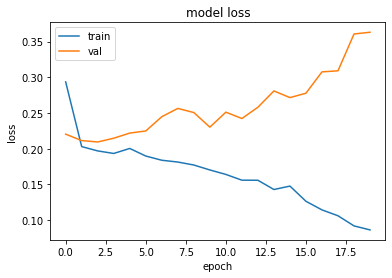

[[9174  407]
 [ 544  223]]
F1 score: 0.3192555476020043
Precision: 0.353968253968254
Recall: 0.2907431551499348
Accuracy: 0.9080981832238114
ROC AUC: 0.6241316234991925


In [35]:
cnn(df_ext_square)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 200)               37400     
_________________________________________________________________
dropout_226 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_227 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_228 (Dropout)        (None, 100)               0         
__________

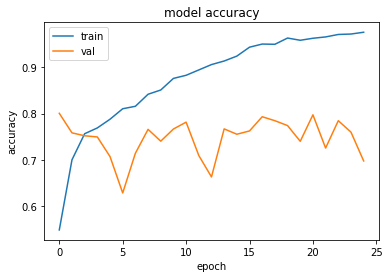

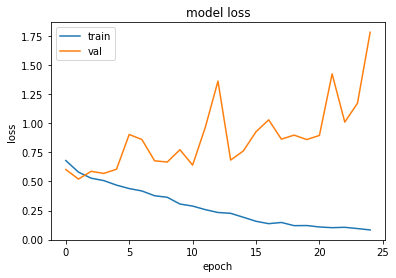

[[6451 3130]
 [ 204  563]]
F1 score: 0.2524663677130045
Precision: 0.15245058218250745
Recall: 0.7340286831812256
Accuracy: 0.6778121376111326
ROC AUC: 0.7036702230226137


In [36]:
nn_kfold(df_ext_square, balanced_batches=True)

Training data shape: (16807, 187)
Val data shape: (4202, 187)
Test data shape: (10348, 187)
Input shape: 186
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 186, 1)            0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 185, 32)           96        
_________________________________________________________________
batch_normalization_46 (Batc (None, 185, 32)           128       
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 184, 32)           2080      
_________________________________________________________________
batch_normalization_47 (Batc (None, 184, 32)           128       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 183, 64)           4160      
__________

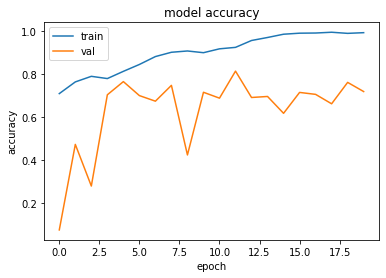

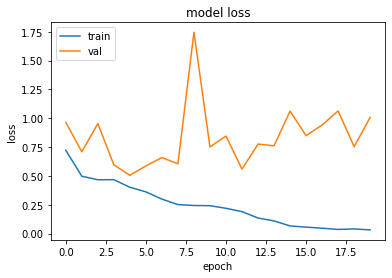

[[6893 2688]
 [ 244  523]]
F1 score: 0.26294620412267466
Precision: 0.16287760822173777
Recall: 0.681877444589309
Accuracy: 0.7166602241979126
ROC AUC: 0.7006610894797083


In [37]:
cnn(df_ext_square, balanced_batches=True)

## Created + log

In [14]:
df_created_log = df_ext_square.copy()

cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_log[str(var) + '_log'] = (df_created_log[var]-df_created_log[var].min()+1).transform(np.log)


df_created_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,4.027136,3.751854,5.221436,5.987958,0.587787,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,4.157319,3.931826,4.513055,5.519058,0.587787,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,4.283587,3.879500,4.908233,6.276643,0.693147,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,4.294561,4.046554,4.143135,6.151029,0.587787,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,4.019980,3.955082,4.964242,6.274008,0.693147,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 200)               48000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
___________

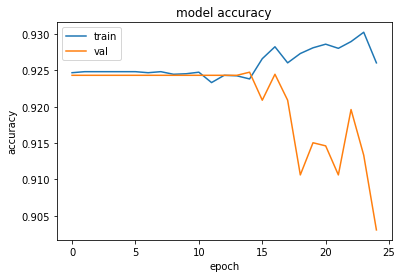

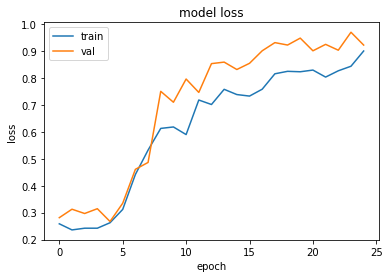

[[9137  444]
 [ 574  193]]
F1 score: 0.27492877492877493
Precision: 0.3029827315541601
Recall: 0.2516297262059974
Accuracy: 0.9016235021260147
ROC AUC: 0.6026440041112442


In [20]:
nn_kfold(df_created_log)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 236, 64)           4160      
___________

4202/4202 [==============================] - 19s 5ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.30578393440184737;  accuracy of 0.9219419360160828; precision of 0.9219419360160828; recall of 0.9219419360160828; AUC of 0.9565480947494507;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


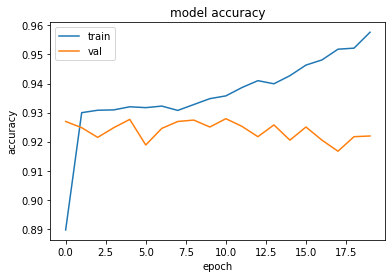

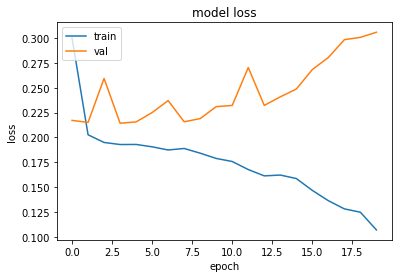

[[9335  246]
 [ 608  159]]
F1 score: 0.2713310580204778
Precision: 0.3925925925925926
Recall: 0.20730117340286833
Accuracy: 0.91747197526092
ROC AUC: 0.5908126783411377


In [17]:
cnn(df_created_log)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               48000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

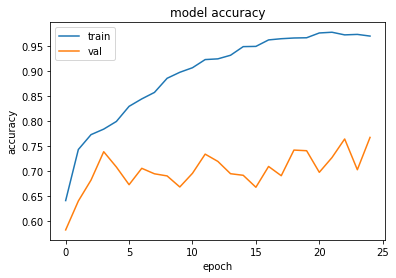

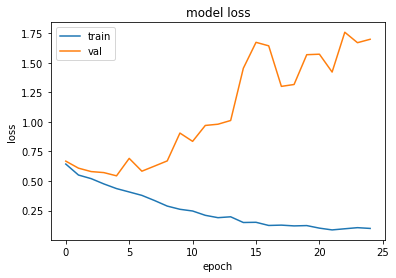

[[7465 2116]
 [ 240  527]]
F1 score: 0.30909090909090914
Precision: 0.1993946273174423
Recall: 0.6870925684485006
Accuracy: 0.7723231542327019
ROC AUC: 0.7331193976779609


In [15]:
nn_kfold(df_created_log, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 236, 64)           4160      
___________

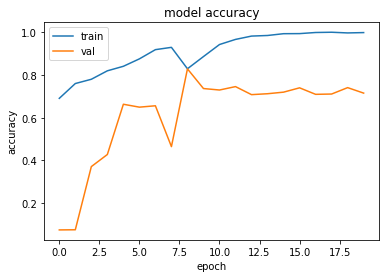

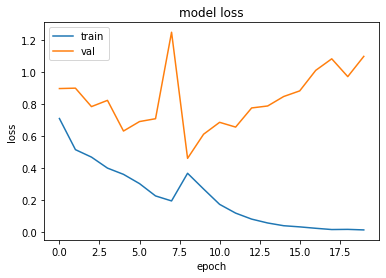

[[6894 2687]
 [ 237  530]]
F1 score: 0.2660642570281124
Precision: 0.16474976686353746
Recall: 0.6910039113428944
Accuracy: 0.7174333204483958
ROC AUC: 0.7052765094758516


In [16]:
cnn(df_created_log, balanced_batches=True)

## Created + sqrt

In [15]:
df_created_sqrt = df_ext_square.copy()

# cont, non_cont, cat_encode, = var_type(df_created_log)

# log of all cont columns
for var in cont:
    df_created_sqrt[str(var) + '_sqrt'] = (df_created_sqrt[var]-df_created_sqrt[var].min()+1).transform(np.sqrt)


df_created_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,7.489993,6.526868,13.608821,19.964969,1.341641,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,7.993748,7.141428,9.549869,15.792403,1.341641,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,8.514693,6.957011,11.636151,23.065125,1.414214,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,8.561542,7.563068,7.937254,21.661025,1.341641,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,7.463243,7.224957,11.966620,23.034756,1.414214,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
___________

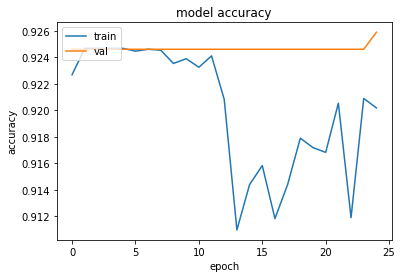

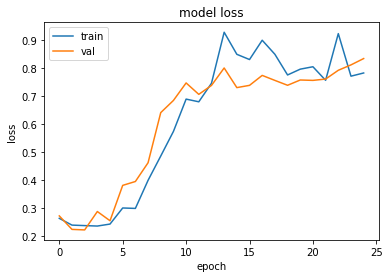

[[9561   20]
 [ 728   39]]
F1 score: 0.0944309927360775
Precision: 0.6610169491525424
Recall: 0.05084745762711865
Accuracy: 0.9277155005798222
ROC AUC: 0.5243799964265434


In [21]:
nn_kfold(df_created_sqrt)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 64)           4160      
___________

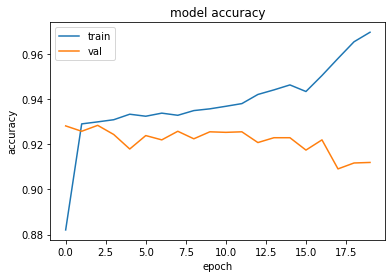

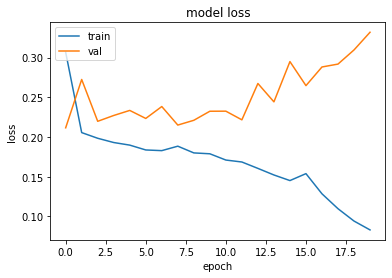

[[9240  341]
 [ 578  189]]
F1 score: 0.29144178874325366
Precision: 0.35660377358490564
Recall: 0.24641460234680573
Accuracy: 0.9111905682257441
ROC AUC: 0.6054116639747805


In [19]:
cnn(df_created_sqrt)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

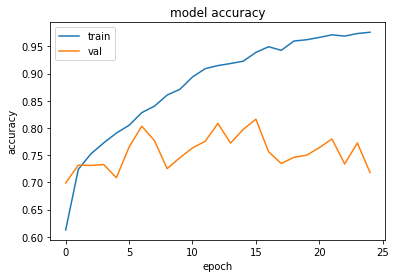

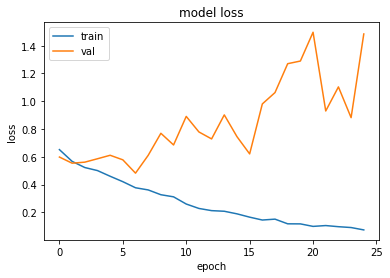

[[6609 2972]
 [ 216  551]]
F1 score: 0.2568764568764569
Precision: 0.15640079477717855
Recall: 0.7183833116036505
Accuracy: 0.6919211441824508
ROC AUC: 0.7040930230912523


In [18]:
nn_kfold(df_created_sqrt, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 64)           4160      
___________

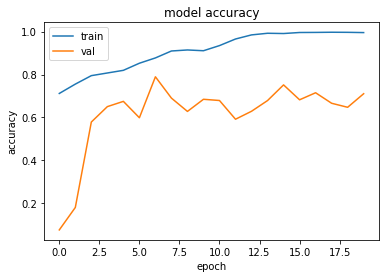

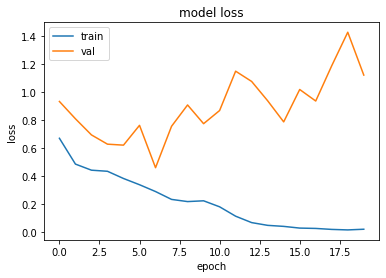

[[6730 2851]
 [ 220  547]]
F1 score: 0.26266506602641054
Precision: 0.16097704532077692
Recall: 0.7131681877444589
Accuracy: 0.7032276768457673
ROC AUC: 0.707800042103103


In [19]:
cnn(df_created_sqrt, balanced_batches=True)

## Created + poly

In [16]:
df_created_poly = df_ext_square.copy()

# 1+5x+8x2
for var in cont:
    df_created_poly[str(var) + '_poly'] = (1+(5*df_created_poly[var])+(8*np.power(df_created_poly[var],2)))


df_created_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_poly,serum_zinc_poly,serum_creatinine_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,103080.92,42998.00,284295.92,1383865.88,10.12,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,117734.00,53415.68,71461.12,569084.68,10.12,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,135018.28,50070.52,153929.48,2413954.00,14.00,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,136686.28,61829.08,35179.00,1893555.52,10.12,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,102355.72,54996.08,171727.52,2401665.08,14.00,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               48000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

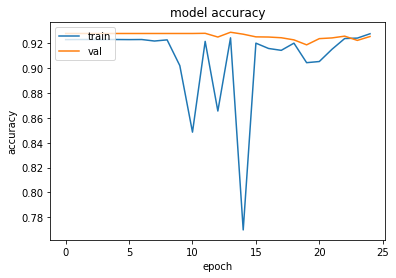

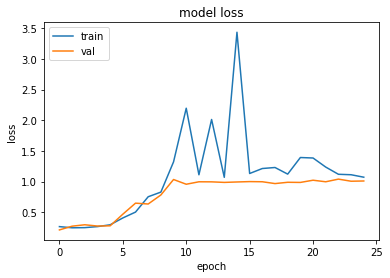

[[9471  110]
 [ 696   71]]
F1 score: 0.14978902953586498
Precision: 0.39226519337016574
Recall: 0.09256844850065189
Accuracy: 0.9221105527638191
ROC AUC: 0.5405436961217381


In [17]:
nn_kfold(df_created_poly)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 236, 64)           4160      
___________

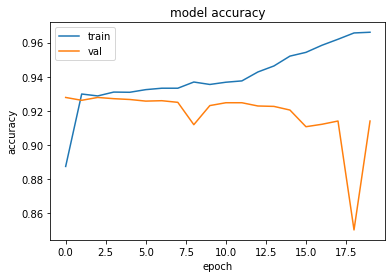

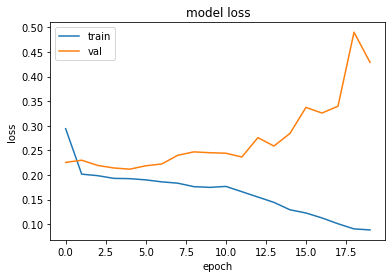

[[9336  245]
 [ 609  158]]
F1 score: 0.27008547008547007
Precision: 0.3920595533498759
Recall: 0.20599739243807041
Accuracy: 0.91747197526092
ROC AUC: 0.5902129744780896


In [18]:
cnn(df_created_poly)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

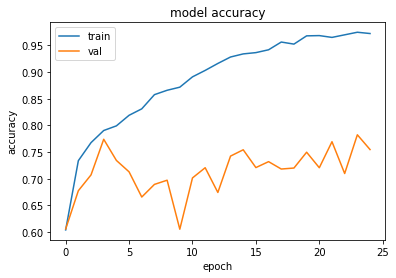

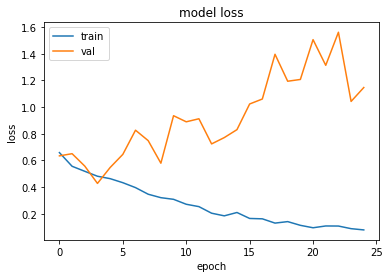

[[7181 2400]
 [ 252  515]]
F1 score: 0.2797392721347094
Precision: 0.17667238421955403
Recall: 0.6714471968709257
Accuracy: 0.7437185929648241
ROC AUC: 0.7104757119935465


In [19]:
nn_kfold(df_created_poly, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 238, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 237, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 236, 64)           4160      
___________

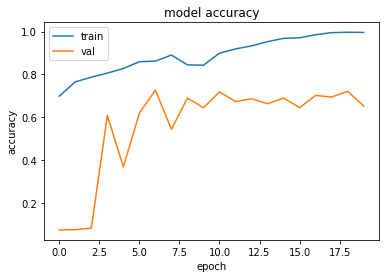

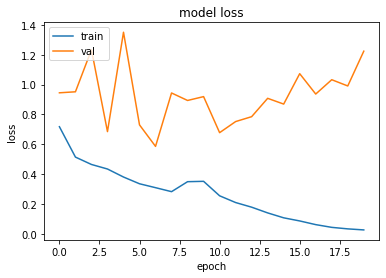

[[6261 3320]
 [ 188  579]]
F1 score: 0.24817831118731246
Precision: 0.14849961528597075
Recall: 0.7548891786179922
Accuracy: 0.6609972941631234
ROC AUC: 0.7041850130643452


In [20]:
cnn(df_created_poly, balanced_batches=True)

## Created + sin

In [23]:
df_created_sin = df_ext_square.copy()

cont, non_cont, cat_encode, = var_type(df_created_sin)

# log of all cont columns
for var in cont:
    df_created_sin[str(var) + '_sin'] = (df_created_sin[var]-df_created_sin[var].min()+1).transform(np.sin)


df_created_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sin,serum_zinc_sin,serum_creatinine_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,-0.433766,-0.982287,0.153359,0.373025,0.973848,0.909297,0.141120,-0.193473,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,0.876309,0.670229,-0.093676,-0.937084,0.973848,0.141120,0.141120,0.816743,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,-0.240974,-0.956893,-0.306502,-0.877604,0.909297,0.909297,0.909297,0.816743,0.935189,0.561730
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,-0.864105,0.606246,0.167356,-0.892426,0.973848,0.141120,0.412118,-0.176076,0.963042,0.999822
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,-0.750400,0.934579,-0.967021,0.323247,0.909297,0.841471,0.656987,-0.629888,0.976083,-0.442744


Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

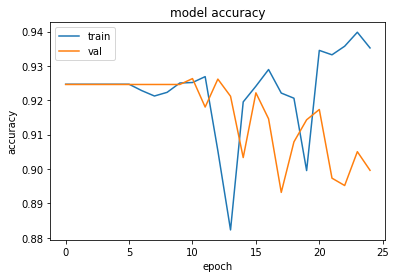

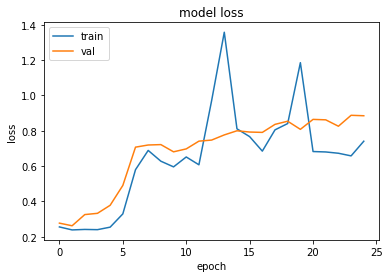

[[9079  502]
 [ 562  205]]
F1 score: 0.2781546811397557
Precision: 0.28995756718529
Recall: 0.26727509778357234
Accuracy: 0.8971781986857363
ROC AUC: 0.6074398659776853


In [24]:
nn_kfold(df_created_sin)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 238, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 237, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 236, 64)           4160      
__________

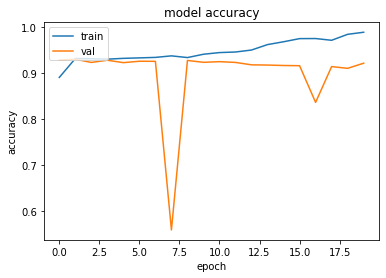

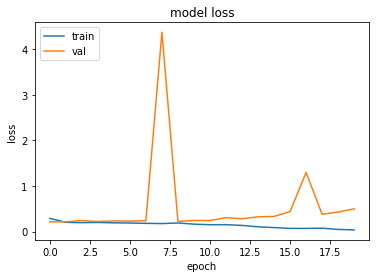

[[9362  219]
 [ 610  157]]
F1 score: 0.2747156605424322
Precision: 0.4175531914893617
Recall: 0.2046936114732725
Accuracy: 0.9198879010436799
ROC AUC: 0.5909179360988114


In [25]:
cnn(df_created_sin)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               48000     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

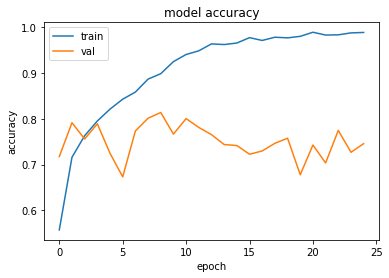

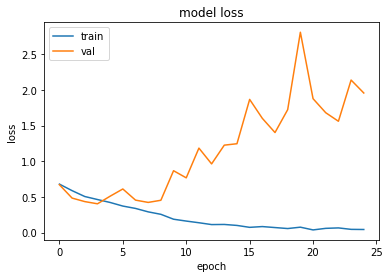

[[7087 2494]
 [ 227  540]]
F1 score: 0.28413575374901345
Precision: 0.17798286090969018
Recall: 0.7040417209908736
Accuracy: 0.7370506378044066
ROC AUC: 0.7218674318345455


In [26]:
nn_kfold(df_created_sin, balanced_batches=True)

Training data shape: (16807, 240)
Val data shape: (4202, 240)
Test data shape: (10348, 240)
Input shape: 239
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 239, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 238, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 238, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 237, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 237, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 236, 64)           4160      
__________

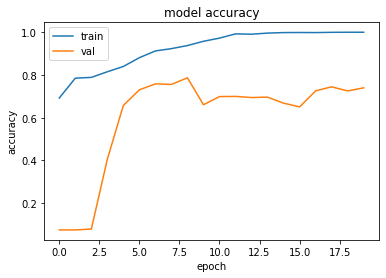

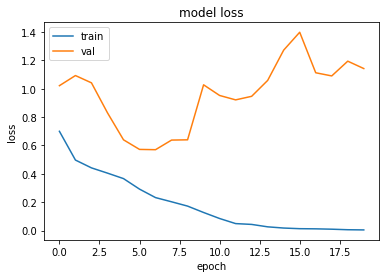

[[7075 2506]
 [ 239  528]]
F1 score: 0.27782162588792425
Precision: 0.17402768622280818
Recall: 0.6883963494132985
Accuracy: 0.7347313490529571
ROC AUC: 0.7134185066135483


In [27]:
cnn(df_created_sin, balanced_batches=True)

## subset of new created featuers - minimize correlation

In [50]:
subset_corr = ['depressed', 'broken_hip','edu_level', 'gender', 'marital_status', 'protein', 
       'sugar', 'fiber', 'fat', 'magnesium', 'iron', 'zinc', 'selenium', 'water', 
       'how_healthy_diet', 'gen_health_cond', 'healthcare_past_yr', 'health_insurance',
        'home_ownership', 'food_security_cat', 'work_type', 'hrs_worked_week',
       'embarassed_mouth', 'manage_$_difficult', 'doc_sleeping_disorder',
       'hrs_sleep', 'smoked_5days', 'sexual_orientation',  'consider_weight','triglyceride', 'tot_cholesterol', 'rbc_folate',
       'fasting_glucose', 'lab_VitD', 'pulse', 'BMI', 
       'monthly_income', 'oral_rec', 'difficult_remembering', 'prob_smell', 'prob_tatse',
       'persistent_cold',  'serum_selenium', 'serum_zinc', 'serum_creatinine', 'lab_VitB12',
        'doc_COPD', 'age_cat', 'not_enough_food', 'food_welfare', 'chronic_condition',
       '#_chronic_condition', 'active', 'hours_screen', 'limited',
       'taste_smell', 'difficult_everyday', 'combined_BP',
       'drugs_alcohol', 'people_per_rooms', 'sexuality', 'race_cat',
       'diet_tot_VitB']

df_min_corr = df_ext_square[subset_corr]

In [51]:
df_min_corr.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,hours_screen,limited,taste_smell,difficult_everyday,combined_BP,drugs_alcohol,people_per_rooms,sexuality,race_cat,diet_tot_VitB
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,2.0,0.0,0.0,0.0,218.0,0.0,0.500000,0.0,3.0,300.415
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,2.0,0.0,0.0,0.0,198.0,0.0,0.250000,0.0,2.0,814.422
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,1.0,0.0,1.0,0.0,198.0,0.0,0.285714,0.0,2.0,288.623
3,0.0,0.0,5.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,8.0,0.0,0.0,0.0,174.0,0.0,0.375000,0.0,1.0,308.428
4,0.0,0.0,5.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,6.0,0.0,0.0,0.0,170.0,0.0,0.428571,0.0,2.0,536.671


Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_349 (Dense)            (None, 200)               21200     
_________________________________________________________________
dropout_301 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_350 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_302 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_351 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_303 (Dropout)        (None, 100)               0         
__________

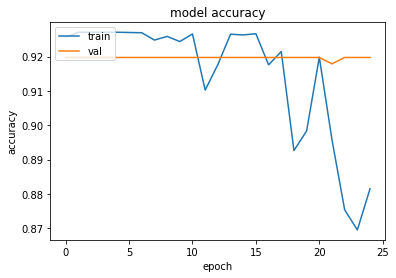

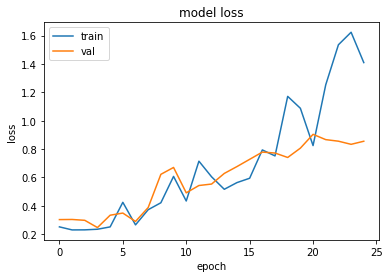

[[9581    0]
 [ 767    0]]
F1 score: 0.0
Precision: 0.0
Recall: 0.0
Accuracy: 0.9258793969849246
ROC AUC: 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
nn_kfold(df_min_corr)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 105, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 104, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 104, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 103, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 103, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 102, 64)           4160      
___________

4202/4202 [==============================] - 10s 2ms/step
------------------------------------------------------------------------
Score for val cnn: loss of 0.3212983359373053;  accuracy of 0.9136125445365906; precision of 0.9136125445365906; recall of 0.9136125445365906; AUC of 0.9548672437667847;
dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_AUC', 'loss', 'accuracy', 'precision', 'recall', 'AUC'])


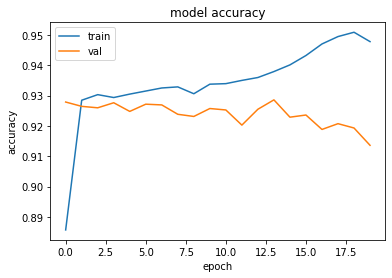

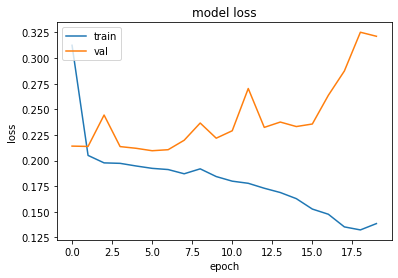

[[9323  258]
 [ 587  180]]
F1 score: 0.2987551867219917
Precision: 0.410958904109589
Recall: 0.23468057366362452
Accuracy: 0.9183417085427136
ROC AUC: 0.6038761390393064


In [16]:
cnn(df_min_corr)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               21200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
___________

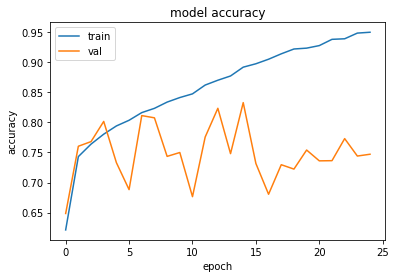

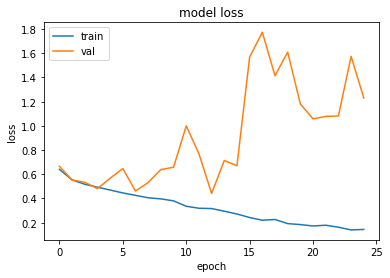

[[7068 2513]
 [ 227  540]]
F1 score: 0.2827225130890052
Precision: 0.17687520471667212
Recall: 0.7040417209908736
Accuracy: 0.7352145342095091
ROC AUC: 0.7208758860668801


In [17]:
nn_kfold(df_min_corr, balanced_batches=True)

Training data shape: (16807, 106)
Val data shape: (4202, 106)
Test data shape: (10348, 106)
Input shape: 105
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 105, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 104, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 104, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 103, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 103, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 102, 64)           4160      
___________

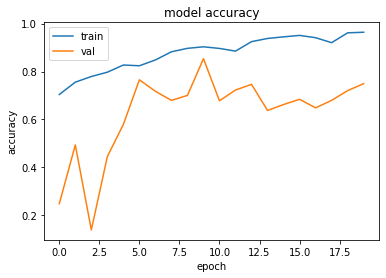

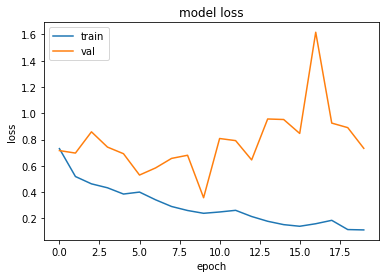

[[7271 2310]
 [ 276  491]]
F1 score: 0.2752242152466368
Precision: 0.1752945376651196
Recall: 0.6401564537157758
Accuracy: 0.7500966370313104
ROC AUC: 0.6995271361575435


In [18]:
cnn(df_min_corr, balanced_batches=True)

## subset of created + log

In [52]:
df_sub_log = df_min_corr.copy()

cont, non_cont, cat_encode, = var_type(df_sub_log)

# log of all cont columns
for var in cont:
    df_sub_log[str(var) + '_log'] = (df_sub_log[var]-df_sub_log[var].min()+1).transform(np.log)


df_sub_log.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,monthly_income_log,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,3.621671,4.027136,3.751854,5.221436,5.987958,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,2.001480,4.157319,3.931826,4.513055,5.519058,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,1.856298,4.283587,3.879500,4.908233,6.276643,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,5.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,3.178054,4.294561,4.046554,4.143135,6.151029,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,5.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,1.609438,4.019980,3.955082,4.964242,6.274008,0.000000,1.945910,4.394449,0.301325,6.287247


Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               27200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

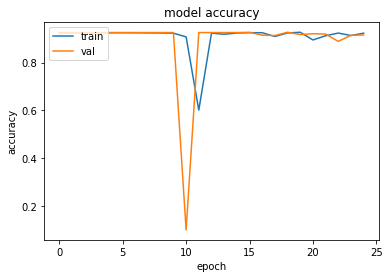

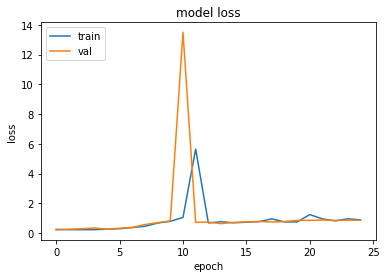

[[9312  269]
 [ 611  156]]
F1 score: 0.26174496644295303
Precision: 0.36705882352941177
Recall: 0.2033898305084746
Accuracy: 0.9149594124468496
ROC AUC: 0.5876567146488725


In [18]:
nn_kfold(df_sub_log)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 135, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 134, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 134, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 133, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 133, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 132, 64)           4160      
___________

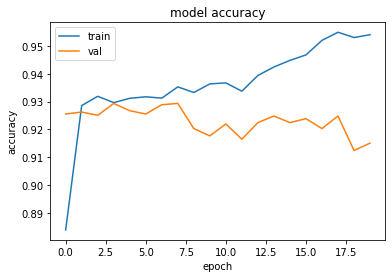

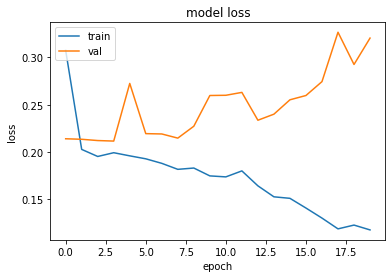

[[9307  274]
 [ 606  161]]
F1 score: 0.26788685524126454
Precision: 0.3701149425287356
Recall: 0.20990873533246415
Accuracy: 0.9149594124468496
ROC AUC: 0.5906552339641133


In [19]:
cnn(df_sub_log)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 200)               27200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_28 (Dropout)         (None, 100)               0         
___________

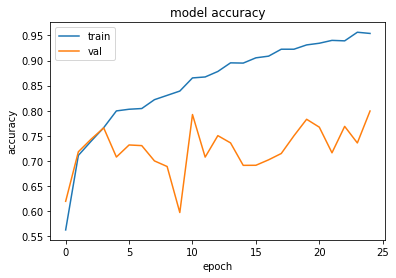

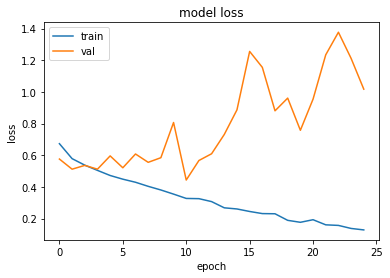

[[7684 1897]
 [ 295  472]]
F1 score: 0.3010204081632653
Precision: 0.19924018573237653
Recall: 0.6153846153846154
Accuracy: 0.7881716273676073
ROC AUC: 0.7086942907838432


In [20]:
nn_kfold(df_sub_log, balanced_batches=True)

Training data shape: (16807, 136)
Val data shape: (4202, 136)
Test data shape: (10348, 136)
Input shape: 135
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 135, 1)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 134, 32)           96        
_________________________________________________________________
batch_normalization_6 (Batch (None, 134, 32)           128       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 133, 32)           2080      
_________________________________________________________________
batch_normalization_7 (Batch (None, 133, 32)           128       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 132, 64)           4160      
___________

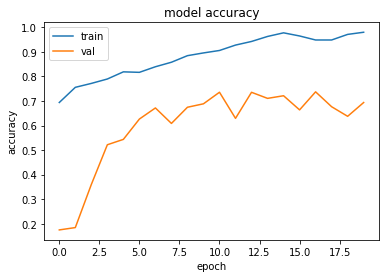

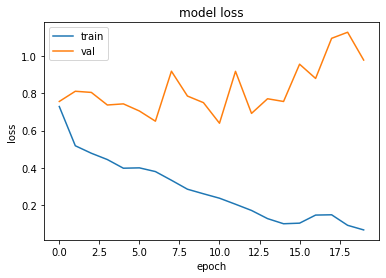

[[6619 2962]
 [ 223  544]]
F1 score: 0.25462204540135736
Precision: 0.1551625784369652
Recall: 0.7092568448500652
Accuracy: 0.6922110552763819
ROC AUC: 0.7000516559079676


In [21]:
cnn(df_sub_log, balanced_batches=True)

## subset created + log +sqrt

In [53]:
df_sub_log_sqrt = df_sub_log.copy()

# cont, non_cont, cat_encode, = var_type(df_sub_log_sqrt)

# log of all cont columns
for var in cont:
    df_sub_log_sqrt[str(var) + '_sqrt'] = (df_sub_log_sqrt[var]-df_sub_log_sqrt[var].min()+1).transform(np.sqrt)


df_sub_log_sqrt.head()

,depressed,broken_hip,edu_level,gender,marital_status,protein,sugar,fiber,fat,magnesium,...,monthly_income_sqrt,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,4.0,0.0,1.0,27.43,146.01,6.4,50.86,144.0,...,6.115554,7.489993,6.526868,13.608821,19.964969,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,5.0,1.0,1.0,75.81,111.54,20.3,60.16,314.0,...,2.720294,7.993748,7.141428,9.549869,15.792403,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,3.0,1.0,1.0,67.11,140.26,16.4,79.30,210.0,...,2.529822,8.514693,6.957011,11.636151,23.065125,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,5.0,0.0,5.0,48.38,27.02,12.8,27.51,169.0,...,4.898979,8.561542,7.563068,7.937254,21.661025,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,5.0,1.0,5.0,95.17,92.63,14.3,100.19,304.0,...,2.236068,7.463243,7.224957,11.966620,23.034756,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 200)               33200     
_________________________________________________________________
dropout_51 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_60 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
___________

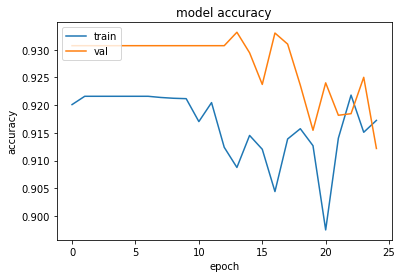

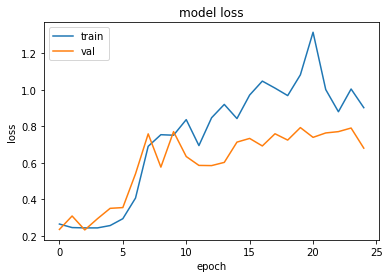

[[9070  511]
 [ 543  224]]
F1 score: 0.2982689747003995
Precision: 0.3047619047619048
Recall: 0.2920469361147327
Accuracy: 0.8981445689988403
ROC AUC: 0.6193561055691083


In [23]:
nn_kfold(df_sub_log_sqrt)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 165, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 164, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 163, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 163, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 162, 64)           4160      
__________

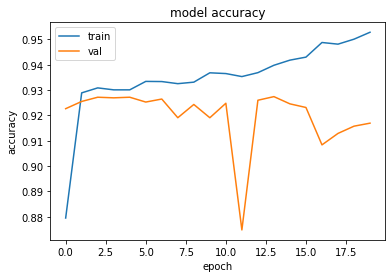

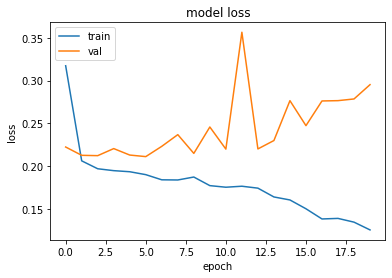

[[9256  325]
 [ 547  220]]
F1 score: 0.33536585365853655
Precision: 0.4036697247706422
Recall: 0.28683181225554105
Accuracy: 0.9157325086973328
ROC AUC: 0.6264552548387611


In [24]:
cnn(df_sub_log_sqrt)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               33200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

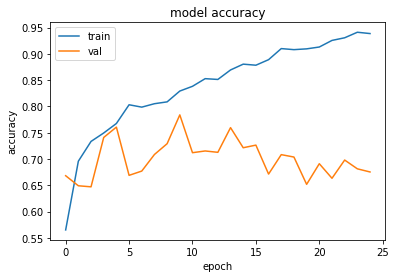

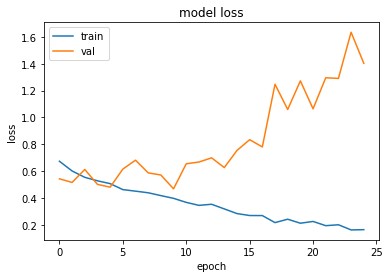

[[6358 3223]
 [ 195  572]]
F1 score: 0.25076720736519076
Precision: 0.15072463768115943
Recall: 0.7457627118644068
Accuracy: 0.6696946269810592
ROC AUC: 0.70468388176458


In [25]:
nn_kfold(df_sub_log_sqrt, balanced_batches=True)

Training data shape: (16807, 166)
Val data shape: (4202, 166)
Test data shape: (10348, 166)
Input shape: 165
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 165, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 164, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 164, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 163, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 163, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 162, 64)           4160      
__________

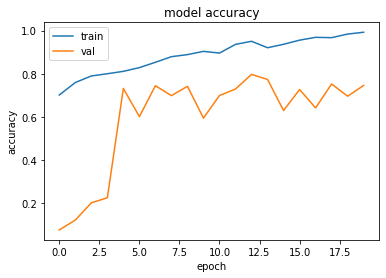

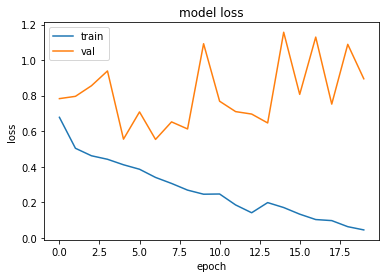

[[7187 2394]
 [ 256  511]]
F1 score: 0.27832244008714596
Precision: 0.17590361445783131
Recall: 0.666232073011734
Accuracy: 0.7439118670274449
ROC AUC: 0.7081812697800555


In [26]:
cnn(df_sub_log_sqrt, balanced_batches=True)

## Created + squared continous columns

In [27]:
df_raw_knn_ext.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_2,serum_zinc_2,serum_creatinine_2,lab_VitB12_2,bone_mineral_density_2,#_chronic_condition_2,hours_screen_2,combined_BP_2,people_per_rooms_2,diet_tot_VitB_2
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,12814.24,5329.00,35419.24,172723.36,0.64,1.0,4.0,47524.0,0.250000,90249.172225
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,14641.00,6625.96,8873.64,70968.96,0.64,4.0,4.0,39204.0,0.062500,663283.194084
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,16796.16,6209.44,19154.56,301401.00,1.00,1.0,1.0,39204.0,0.081633,83303.236129
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,17004.16,7673.76,4356.00,236390.44,0.64,4.0,64.0,30276.0,0.140625,95127.831184
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,12723.84,6822.76,21374.44,299865.76,1.00,0.0,36.0,28900.0,0.183673,288015.762241


Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_251 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_292 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_252 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_293 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_253 (Dropout)        (None, 100)               0         
__________

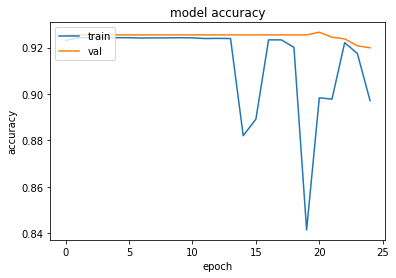

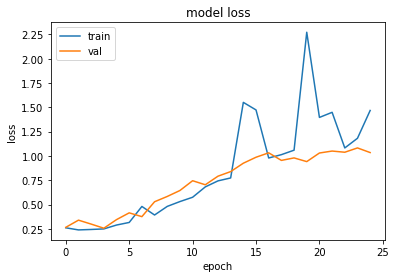

[[9448  133]
 [ 686   81]]
F1 score: 0.16513761467889912
Precision: 0.37850467289719625
Recall: 0.10560625814863103
Accuracy: 0.9208542713567839
ROC AUC: 0.5458623087006593


In [39]:
nn_kfold(df_raw_knn_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 240, 1)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 239, 32)           96        
_________________________________________________________________
batch_normalization_51 (Batc (None, 239, 32)           128       
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 238, 32)           2080      
_________________________________________________________________
batch_normalization_52 (Batc (None, 238, 32)           128       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 237, 64)           4160      
__________

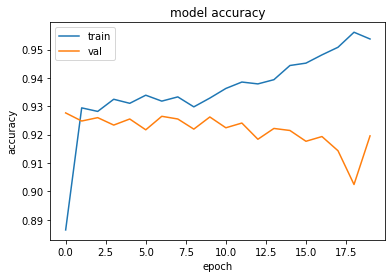

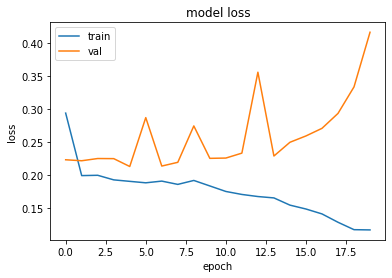

[[9402  179]
 [ 630  137]]
F1 score: 0.25300092336103414
Precision: 0.43354430379746833
Recall: 0.17861799217731422
Accuracy: 0.9218206416698879
ROC AUC: 0.5799675912248641


In [40]:
cnn(df_raw_knn_ext)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_320 (Dense)            (None, 200)               48200     
_________________________________________________________________
dropout_276 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_321 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_277 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_322 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_278 (Dropout)        (None, 100)               0         
__________

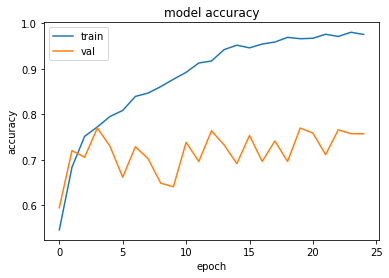

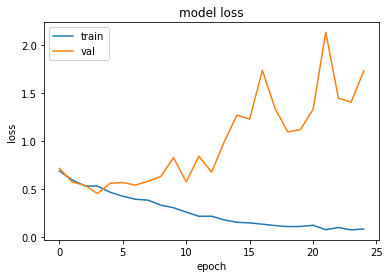

[[7155 2426]
 [ 249  518]]
F1 score: 0.27917003503098897
Precision: 0.17595108695652173
Recall: 0.6753585397653195
Accuracy: 0.741495941244685
ROC AUC: 0.7110745313376227


In [41]:
nn_kfold(df_raw_knn_ext, balanced_batches=True)

Training data shape: (16807, 241)
Val data shape: (4202, 241)
Test data shape: (10348, 241)
Input shape: 240
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 240, 1)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 239, 32)           96        
_________________________________________________________________
batch_normalization_56 (Batc (None, 239, 32)           128       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 238, 32)           2080      
_________________________________________________________________
batch_normalization_57 (Batc (None, 238, 32)           128       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 237, 64)           4160      
__________

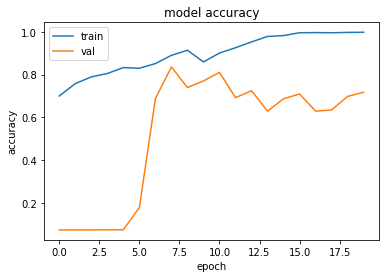

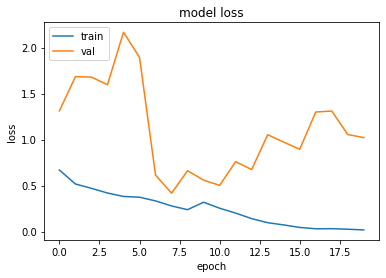

[[6884 2697]
 [ 213  554]]
F1 score: 0.27575908412145345
Precision: 0.17040910489080283
Recall: 0.7222946544980443
Accuracy: 0.7187862388867414
ROC AUC: 0.7204000148599188


In [42]:
cnn(df_raw_knn_ext, balanced_batches=True)

## +log(n)

In [54]:
df_add_log = df_raw_knn_ext.copy()

cont, non_cont, cat_encode, = var_type(df_add_log)

# remove squared values from continous var list
og_cont = []
for i in range(len(cont)):
    if cont[i].endswith('_2') == False:
        og_cont.append(cont[i])

# log of all cont columns
for var in og_cont:
    df_add_log[str(var) + '_log'] = (df_add_log[var]-df_add_log[var].min()+1).transform(np.log)


df_add_log.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_log,serum_zinc_log,serum_creatinine_log,lab_VitB12_log,bone_mineral_density_log,#_chronic_condition_log,hours_screen_log,combined_BP_log,people_per_rooms_log,diet_tot_VitB_log
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,4.027136,3.751854,5.221436,5.987958,0.587787,0.693147,1.098612,4.859812,0.352821,5.708488
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,4.157319,3.931826,4.513055,5.519058,0.587787,1.098612,1.098612,4.691348,0.159630,6.703706
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,4.283587,3.879500,4.908233,6.276643,0.693147,0.693147,0.693147,4.691348,0.189621,5.668580
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,4.294561,4.046554,4.143135,6.151029,0.587787,1.098612,2.197225,4.442651,0.260884,5.734725
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,4.019980,3.955082,4.964242,6.274008,0.693147,0.000000,1.945910,4.394449,0.301325,6.287247


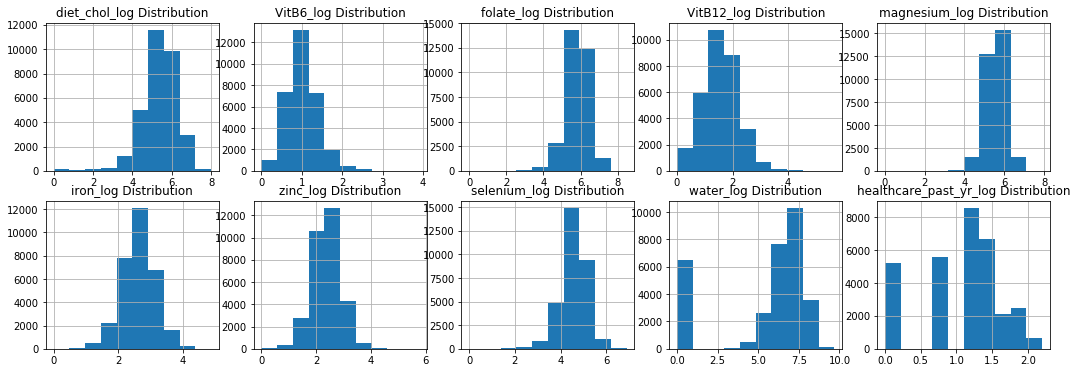

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,6))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    #fig.tight_layout()  # Improves appearance a bit.
    plt.show()

check = ['diet_chol_log',
 'VitB6_log',
 'folate_log',
 'VitB12_log',
 'magnesium_log',
 'iron_log',
 'zinc_log',
 'selenium_log',
 'water_log',
 'healthcare_past_yr_log']

draw_histograms(df_add_log, check, 2, 5)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 200)               58800     
_________________________________________________________________
dropout_27 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
___________

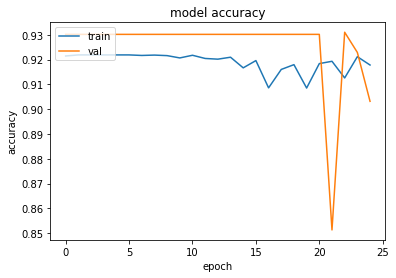

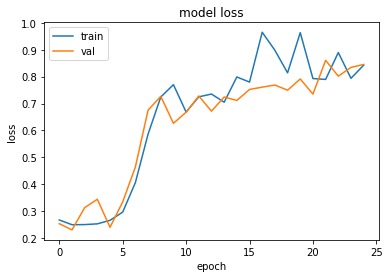

[[9108  473]
 [ 581  186]]
F1 score: 0.2608695652173913
Precision: 0.2822458270106222
Recall: 0.242503259452412
Accuracy: 0.8981445689988403
ROC AUC: 0.5965673587732783


In [22]:
nn_kfold(df_add_log)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 293, 1)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 292, 32)           96        
_________________________________________________________________
batch_normalization_11 (Batc (None, 292, 32)           128       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 291, 32)           2080      
_________________________________________________________________
batch_normalization_12 (Batc (None, 291, 32)           128       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 290, 64)           4160      
___________

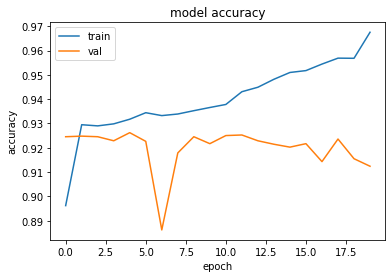

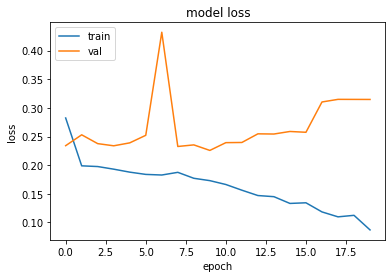

[[9157  424]
 [ 563  204]]
F1 score: 0.2924731182795699
Precision: 0.3248407643312102
Recall: 0.26597131681877445
Accuracy: 0.904619250096637
ROC AUC: 0.6108585318046488


In [23]:
cnn(df_add_log)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 200)               58800     
_________________________________________________________________
dropout_52 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_53 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
__________

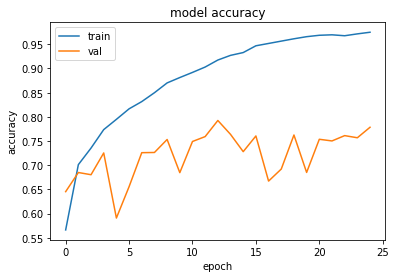

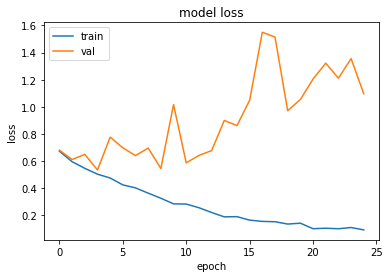

[[7560 2021]
 [ 300  467]]
F1 score: 0.2869431643625192
Precision: 0.1877009646302251
Recall: 0.6088657105606258
Accuracy: 0.7757054503285659
ROC AUC: 0.6989636975723492


In [24]:
nn_kfold(df_add_log, balanced_batches=True)

Training data shape: (16807, 294)
Val data shape: (4202, 294)
Test data shape: (10348, 294)
Input shape: 293
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 293, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 292, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 292, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 291, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 291, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 290, 64)           4160      
__________

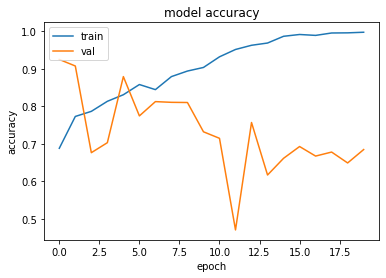

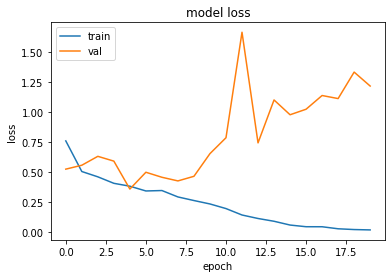

[[6514 3067]
 [ 199  568]]
F1 score: 0.2580645161290323
Precision: 0.1562585969738652
Recall: 0.7405475880052151
Accuracy: 0.6843834557402396
ROC AUC: 0.7102174324537086


In [25]:
cnn(df_add_log, balanced_batches=True)

## +sqrt

In [55]:
df_add_sqrt = df_add_log.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sqrt[str(var) + '_sqrt'] = (df_add_sqrt[var]-df_add_sqrt[var].min()+1).transform(np.sqrt)


df_add_sqrt.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sqrt,serum_zinc_sqrt,serum_creatinine_sqrt,lab_VitB12_sqrt,bone_mineral_density_sqrt,#_chronic_condition_sqrt,hours_screen_sqrt,combined_BP_sqrt,people_per_rooms_sqrt,diet_tot_VitB_sqrt
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,7.489993,6.526868,13.608821,19.964969,1.341641,1.414214,1.732051,11.357817,1.192928,17.361308
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,7.993748,7.141428,9.549869,15.792403,1.341641,1.732051,1.732051,10.440307,1.083087,28.555595
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,8.514693,6.957011,11.636151,23.065125,1.414214,1.414214,1.414214,10.440307,1.099450,17.018314
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,8.561542,7.563068,7.937254,21.661025,1.341641,1.732051,3.000000,9.219544,1.139332,17.590566
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,7.463243,7.224957,11.966620,23.034756,1.414214,1.000000,2.645751,9.000000,1.162604,23.187734


Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 200)               69400     
_________________________________________________________________
dropout_101 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_102 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_119 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_103 (Dropout)        (None, 100)               0         
__________

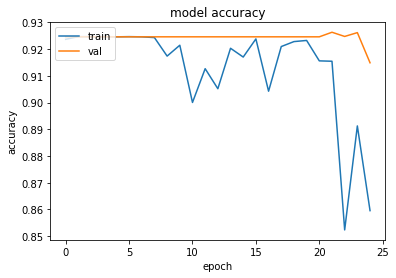

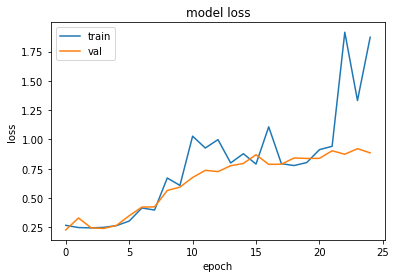

[[9268  313]
 [ 595  172]]
F1 score: 0.2747603833865815
Precision: 0.354639175257732
Recall: 0.2242503259452412
Accuracy: 0.9122535755701585
ROC AUC: 0.5957907511158207


In [30]:
nn_kfold(df_add_sqrt)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 346, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 345, 32)           96        
_________________________________________________________________
batch_normalization_21 (Batc (None, 345, 32)           128       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 344, 32)           2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 344, 32)           128       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 343, 64)           4160      
__________

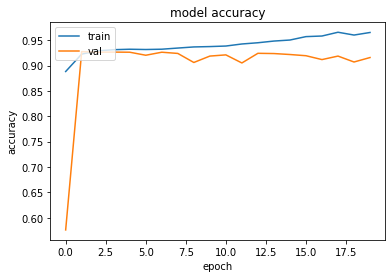

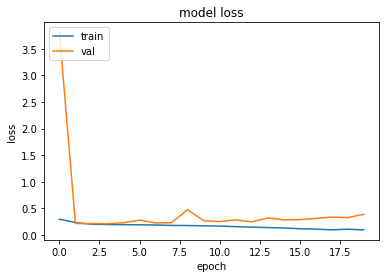

[[9304  277]
 [ 596  171]]
F1 score: 0.2814814814814815
Precision: 0.38169642857142855
Recall: 0.22294654498044328
Accuracy: 0.9156358716660224
ROC AUC: 0.5970175789300505


In [31]:
cnn(df_add_sqrt)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 200)               69400     
_________________________________________________________________
dropout_126 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_127 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_148 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_128 (Dropout)        (None, 100)               0         
__________

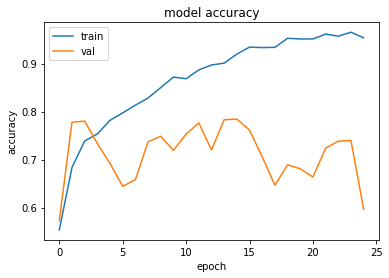

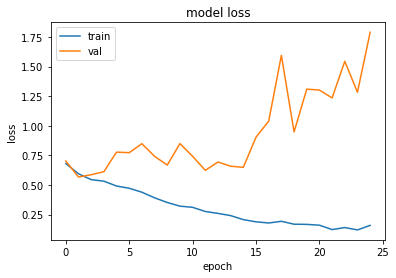

[[5558 4023]
 [ 146  621]]
F1 score: 0.22953243393088152
Precision: 0.13372093023255813
Recall: 0.8096479791395046
Accuracy: 0.5971202164669501
ROC AUC: 0.6948772199214901


In [32]:
nn_kfold(df_add_sqrt, balanced_batches=True)

Training data shape: (16807, 347)
Val data shape: (4202, 347)
Test data shape: (10348, 347)
Input shape: 346
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 346, 1)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 345, 32)           96        
_________________________________________________________________
batch_normalization_26 (Batc (None, 345, 32)           128       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 344, 32)           2080      
_________________________________________________________________
batch_normalization_27 (Batc (None, 344, 32)           128       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 343, 64)           4160      
__________

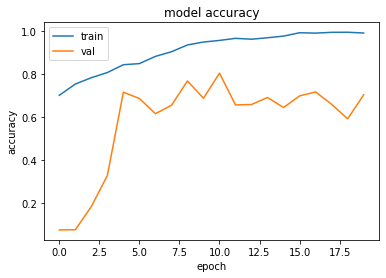

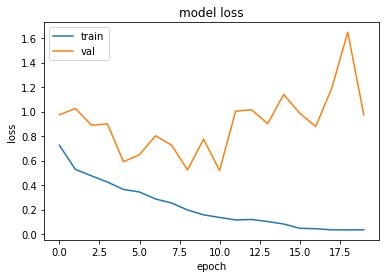

[[6724 2857]
 [ 241  526]]
F1 score: 0.2534939759036145
Precision: 0.15548329884717707
Recall: 0.6857887874837028
Accuracy: 0.7006184770003866
ROC AUC: 0.6937972222566202


In [33]:
cnn(df_add_sqrt, balanced_batches=True)

## + polynomial

In [56]:
df_add_poly = df_add_sqrt.copy()

# original continuous variables is og_cont

# 1+5x+8x2
for var in og_cont:
    df_add_poly[str(var) + '_poly'] = (1+(5*df_add_poly[var])+(8*np.power(df_add_poly[var],2)))


df_add_poly.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_poly,serum_zinc_poly,serum_creatinine_poly,lab_VitB12_poly,bone_mineral_density_poly,#_chronic_condition_poly,hours_screen_poly,combined_BP_poly,people_per_rooms_poly,diet_tot_VitB_poly
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,103080.92,42998.00,284295.92,1383865.88,10.12,14.0,43.0,381283.0,5.500000,7.234965e+05
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,117734.00,53415.68,71461.12,569084.68,10.12,43.0,43.0,314623.0,2.750000,5.310339e+06
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,135018.28,50070.52,153929.48,2413954.00,14.00,14.0,14.0,314623.0,3.081633,6.678700e+05
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,136686.28,61829.08,35179.00,1893555.52,10.12,43.0,553.0,243079.0,4.000000,7.625658e+05
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,102355.72,54996.08,171727.52,2401665.08,14.00,1.0,319.0,232051.0,4.612245,2.306810e+06


Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 200)               80000     
_________________________________________________________________
dropout_151 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_176 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_152 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_177 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_153 (Dropout)        (None, 100)               0         
__________

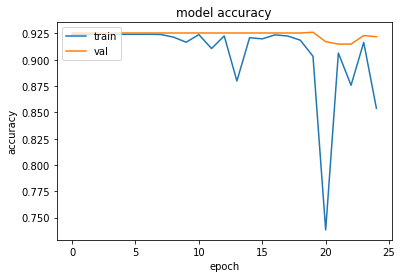

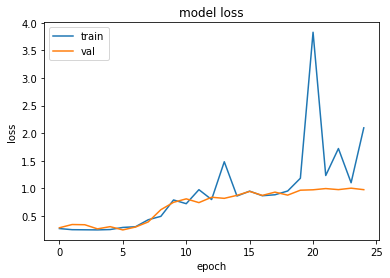

[[9400  181]
 [ 662  105]]
F1 score: 0.1994301994301994
Precision: 0.36713286713286714
Recall: 0.13689700130378096
Accuracy: 0.9185349826053344
ROC AUC: 0.5590027225493959


In [35]:
nn_kfold(df_add_poly)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 399, 1)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 398, 32)           96        
_________________________________________________________________
batch_normalization_31 (Batc (None, 398, 32)           128       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 397, 32)           2080      
_________________________________________________________________
batch_normalization_32 (Batc (None, 397, 32)           128       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 396, 64)           4160      
__________

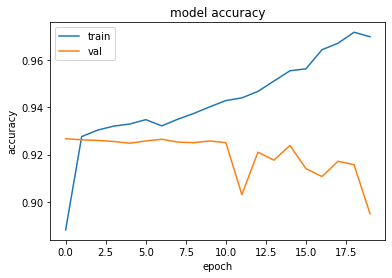

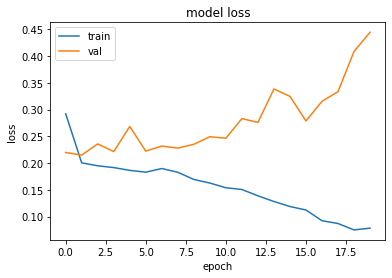

[[8947  634]
 [ 523  244]]
F1 score: 0.2966565349544073
Precision: 0.27790432801822323
Recall: 0.318122555410691
Accuracy: 0.8881909547738693
ROC AUC: 0.6259749610369393


In [36]:
cnn(df_add_poly)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 200)               80000     
_________________________________________________________________
dropout_176 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_177 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_206 (Dense)            (None, 100)               20100     
_________________________________________________________________
dropout_178 (Dropout)        (None, 100)               0         
__________

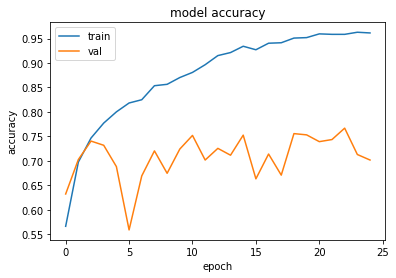

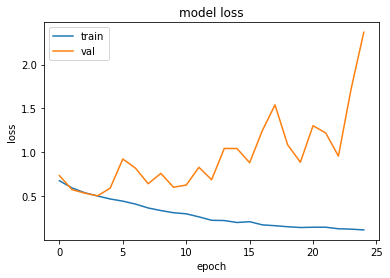

[[6512 3069]
 [ 203  564]]
F1 score: 0.2563636363636364
Precision: 0.15524360033030554
Recall: 0.7353324641460235
Accuracy: 0.6838036335523773
ROC AUC: 0.7075054972854112


In [37]:
nn_kfold(df_add_poly, balanced_batches=True)

Training data shape: (16807, 400)
Val data shape: (4202, 400)
Test data shape: (10348, 400)
Input shape: 399
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 399, 1)            0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 398, 32)           96        
_________________________________________________________________
batch_normalization_36 (Batc (None, 398, 32)           128       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 397, 32)           2080      
_________________________________________________________________
batch_normalization_37 (Batc (None, 397, 32)           128       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 396, 64)           4160      
__________

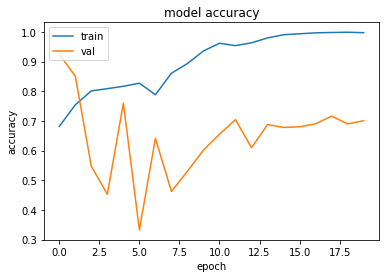

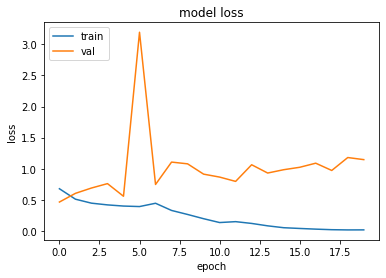

[[6597 2984]
 [ 218  549]]
F1 score: 0.25534883720930235
Precision: 0.1553920181149165
Recall: 0.7157757496740548
Accuracy: 0.6905682257441051
ROC AUC: 0.7021630026942447


In [38]:
cnn(df_add_poly, balanced_batches=True)

## +sin()

In [57]:
df_add_sin = df_add_poly.copy()

# original continuous variables is og_cont

# log of all cont columns
for var in og_cont:
    df_add_sin[str(var) + '_sin'] = (df_add_sin[var]-df_add_sin[var].min()+1).transform(np.sin)


df_add_sin.head()

,depressed,broken_hip,doc_osteoporosis,race_ethnicity,edu_level,#_ppl_household,age,gender,annual_HI,marital_status,...,serum_selenium_sin,serum_zinc_sin,serum_creatinine_sin,lab_VitB12_sin,bone_mineral_density_sin,#_chronic_condition_sin,hours_screen_sin,combined_BP_sin,people_per_rooms_sin,diet_tot_VitB_sin
0,0.0,0.0,0.0,4.0,4.0,4.0,44.0,0.0,11.0,1.0,...,-0.433766,-0.982287,0.153359,0.373025,0.973848,0.909297,0.141120,-0.193473,0.989109,-0.176958
1,0.0,0.0,0.0,3.0,5.0,2.0,70.0,1.0,11.0,1.0,...,0.876309,0.670229,-0.093676,-0.937084,0.973848,0.141120,0.141120,0.816743,0.921947,-0.984074
2,0.0,0.0,0.0,3.0,3.0,2.0,73.0,1.0,5.8,1.0,...,-0.240974,-0.956893,-0.306502,-0.877604,0.909297,0.909297,0.909297,0.816743,0.935189,0.561730
3,0.0,0.0,0.0,2.0,5.0,3.0,18.0,0.0,11.0,5.0,...,-0.864105,0.606246,0.167356,-0.892426,0.973848,0.141120,0.412118,-0.176076,0.963042,0.999822
4,0.0,0.0,0.0,3.0,5.0,3.0,19.0,1.0,11.0,5.0,...,-0.750400,0.934579,-0.967021,0.323247,0.909297,0.841471,0.656987,-0.629888,0.976083,-0.442744


Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 200)               90600     
_________________________________________________________________
dropout_76 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
__________

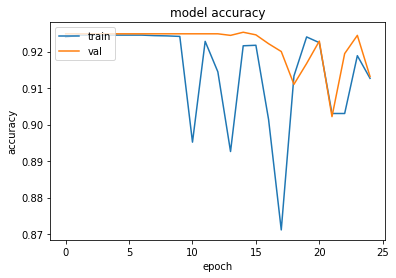

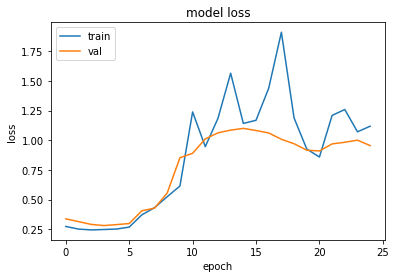

[[9250  331]
 [ 618  149]]
F1 score: 0.23897353648757017
Precision: 0.3104166666666667
Recall: 0.19426336375488917
Accuracy: 0.9082914572864321
ROC AUC: 0.5798579108723303


In [30]:
nn_kfold(df_add_sin)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 452, 1)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 451, 32)           96        
_________________________________________________________________
batch_normalization_16 (Batc (None, 451, 32)           128       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 450, 32)           2080      
_________________________________________________________________
batch_normalization_17 (Batc (None, 450, 32)           128       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 449, 64)           4160      
__________

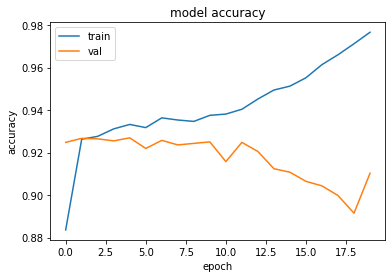

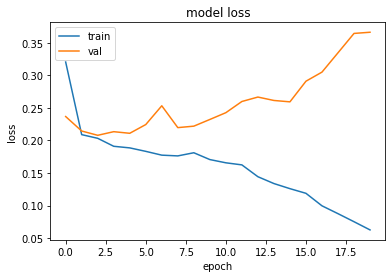

[[9257  324]
 [ 572  195]]
F1 score: 0.30326594090202175
Precision: 0.37572254335260113
Recall: 0.2542372881355932
Accuracy: 0.9134132199458833
ROC AUC: 0.6102101793981379


In [31]:
cnn(df_add_sin)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               90600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
___________

Exception ignored in: <function BaseSession._Callable.__del__ at 0x1427c9ef0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py", line 1467, in __del__
    def __del__(self):
KeyboardInterrupt


------------------------------------------------------------------------
Training for fold 1 ...
7003/7003 [==============================] - 6s 853us/step
------------------------------------------------------------------------
Score for fold 1: loss of 0.8151647460370443;  accuracy of 0.7843781113624573; precision of 0.7843781113624573; recall of 0.7843781113624573; AUC of 0.8842990398406982;
------------------------------------------------------------------------
Training for fold 2 ...
7003/7003 [==============================] - 6s 808us/step
------------------------------------------------------------------------
Score for fold 2: loss of 1.683803799270511;  accuracy of 0.7231186628341675; precision of 0.7231186628341675; recall of 0.7231186628341675; AUC of 0.7864860892295837;
------------------------------------------------------------------------
Training for fold 3 ...
7003/7003 [==============================] - 7s 996us/step
-------------------------------------------------

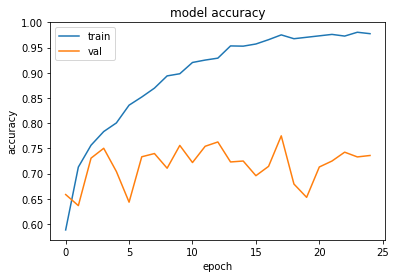

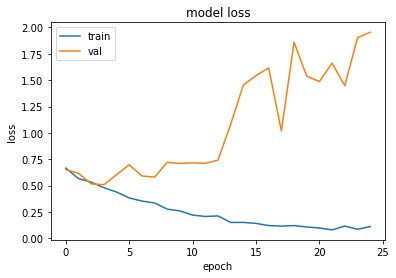

[[6973 2608]
 [ 236  531]]
F1 score: 0.27188940092165903
Precision: 0.16916215355208666
Recall: 0.6923076923076923
Accuracy: 0.7251642829532277
ROC AUC: 0.7100511428869638


In [58]:
nn_kfold(df_add_sin, balanced_batches=True)

Training data shape: (16807, 453)
Val data shape: (4202, 453)
Test data shape: (10348, 453)
Input shape: 452
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 452, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 451, 32)           96        
_________________________________________________________________
batch_normalization_1 (Batch (None, 451, 32)           128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 450, 32)           2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 450, 32)           128       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 449, 64)           4160      
___________

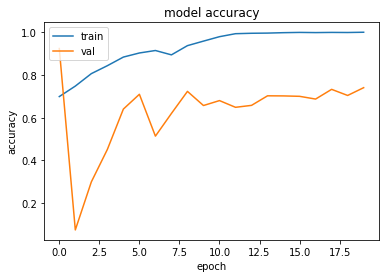

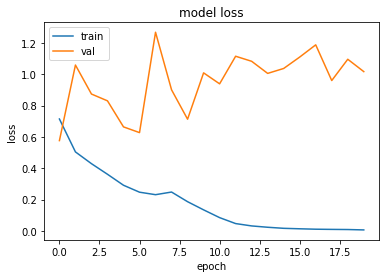

[[7025 2556]
 [ 250  517]]
F1 score: 0.26927083333333335
Precision: 0.16823950536934593
Recall: 0.6740547588005215
Accuracy: 0.7288364901430228
ROC AUC: 0.7036383803396199


In [59]:
cnn(df_add_sin, balanced_batches=True)